# Capstone 3 - Data Cleaning

## Motivation
This project aims to understand how environmental noise affects school performance in New York City between the years 2016 and 2019.

### Preparation
Import relevant packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta

import geopandas as gpd
from shapely.geometry import Point

## SONYC data

We are using the dataset SONYC-UST v2.3, obtained from the [SONYC website](https://wp.nyu.edu/sonyc/resources/).

Documentation [here](https://zenodo.org/records/3966543).

In [2]:
# Load SONYC data
noise_data = pd.read_csv("annotations.csv")

In [3]:
# Check dataframe
noise_data.head()

,split,sensor_id,audio_filename,annotator_id,borough,block,latitude,longitude,year,week,...,7-X_other-unknown-human-voice_proximity,8-1_dog-barking-whining_proximity,1_engine_presence,2_machinery-impact_presence,3_non-machinery-impact_presence,4_powered-saw_presence,5_alert-signal_presence,6_music_presence,7_human-voice_presence,8_dog_presence
0,test,0,00_026884.wav,-6,1,547,40.72951,-73.99388,2019,43,...,-1,-1,-1,1,0,-1,-1,-1,-1,-1
1,test,0,00_026884.wav,-4,1,547,40.72951,-73.99388,2019,43,...,-1,-1,1,-1,-1,-1,-1,-1,-1,-1
2,test,0,00_026884.wav,-3,1,547,40.72951,-73.99388,2019,43,...,-1,-1,1,-1,-1,-1,-1,-1,-1,-1
3,test,0,00_026884.wav,-1,1,547,40.72951,-73.99388,2019,43,...,-1,-1,-1,0,0,-1,-1,-1,-1,-1
4,test,0,00_026884.wav,0,1,547,40.72951,-73.99388,2019,43,...,-1,-1,1,0,1,0,0,0,0,0


In [4]:
# Check dataframe info
noise_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62022 entries, 0 to 62021
Data columns (total 78 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   split                                         62022 non-null  object 
 1   sensor_id                                     62022 non-null  int64  
 2   audio_filename                                62022 non-null  object 
 3   annotator_id                                  62022 non-null  int64  
 4   borough                                       62022 non-null  int64  
 5   block                                         62022 non-null  int64  
 6   latitude                                      62022 non-null  float64
 7   longitude                                     62022 non-null  float64
 8   year                                          62022 non-null  int64  
 9   week                                          62022 non-null 

### Initial cleaning

#### Drop columns
There are a few columns that we can remove outright since they are not informative for our data analysis. These are:
- `split`: The data split. (train, validate, test)
- `annotator_id`: The anonymous ID of the annotator.

In [5]:
# Create a list of columns to drop.
drop_cols = ['split', 'annotator_id']

# Drop the columns
noise_data = noise_data.drop(drop_cols, axis=1)

Note that while `audio_filename` might not seem important for our analysis purposes, we will need to retain it while cleaning the data. Multiple SONYC team members worked on annotating the same recordings, meaning multiple annotation rows exist for one particular audio recording. We would like to control for noise in the data where we can by eliminating any duplicate information for one audio recording. We can drop this column after we are finished cleaning the data. 

#### Date and time conversion
Let's put the time data into a usable format. Currently, the date and time of each recording are recorded as follows:
- `year`: the year the recording is from
- `week`: the week of the year the recording is from
- `day`: the day of the week the recording is from, with Monday as the start (`0`=Monday)
- `hour`: the hour of the day the recording is from

In [6]:
# Add a column for date in YYYY-MM-DD format
noise_data['date'] = noise_data.apply(
    lambda row: datetime.strptime(f"{row['year']}-{row['week']}-{row['day']}", "%Y-%W-%w"), #%w accounts for Monday start
    axis=1
)

# Add a column for time in 24-hour format
noise_data['time'] = noise_data['hour'].apply(lambda hour: f"{hour:02}:00")

In [7]:
# Check new column
noise_data[['date', 'time']].head()

,date,time
0,2019-10-31,08:00
1,2019-10-31,08:00
2,2019-10-31,08:00
3,2019-10-31,08:00
4,2019-10-31,08:00


#### Check for null values

In [8]:
# Check whether any null values exist in the dataframe
noise_data.isnull().values.any()

False

### Sensors

In [9]:
# Calculate number of unique sensors in the dataset
len(noise_data["sensor_id"].unique())

56

There are 56 unique sensors in our dataset.

To control for sampling frequency, let's look at how many total recordings exist for each sensor.

In [10]:
# Group by sensor_id and count unique audio_filename
recording_counts = noise_data.groupby('sensor_id')['audio_filename'].nunique().reset_index()

# Rename the columns for clarity
recording_counts.columns = ['sensor_id', 'unique_recordings_count']

In [11]:
recording_counts

,sensor_id,unique_recordings_count
0,0,509
1,1,1146
2,2,654
3,3,598
4,4,685
5,5,407
6,6,1101
7,7,333
8,8,86
9,9,275


### Sound taxonomy
Our `noise_data` dataframe has multiple columns representing categories from SONYC's sound taxonomy. The naming scheme (from SONYC's [Zenodo page documentation](https://zenodo.org/records/3966543)) for these columns is as follows:
- `<coarse_id>-<fine_id>_<fine_name>_presence`: Columns of this form indicate the presence of fine-level class. `1` if present, `0` if not present. If `-1`, then the class was not labeled in this annotation because the annotation was performed by a SONYC team member who only annotated one coarse group of classes at a time when annotating the verified subset.
- `<coarse_id>_<coarse_name>_presence`: Columns of this form indicate the presence of a coarse-level class. `1` if present, `0` if not present. If `-1`, then the class was not labeled in this annotation because the annotation was performed by a SONYC team member who only annotated one coarse group of classes at a time when annotating the verified subset. These columns are computed from the fine-level class presence columns and are presented here for convenience when training on only coarse-level classes.
- `<coarse_id>-<fine_id>_<fine_name>_proximity`: Columns of this form indicate the proximity of a fine-level class. After indicating the presence of a fine-level class, citizen science annotators were asked to indicate the proximity of the sound event to the sensor. Only the citizen science volunteers performed this task, and therefore this data is not included in the verified annotations. This column may take on one of the following four values: (`near`, `far`, `notsure`, `-1`). If `-1`, then the proximity was not annotated because either the annotation was not performed by a citizen science volunteer, or the citizen science volunteer did not indicate the presence of the class.

In [12]:
# Create the main categories
main_categories = ['engine', 'machinery-impact', 'non-machinery-impact', 
                   'powered-saw', 'alert-signal', 'music', 'human-voice', 'dog']

Let's check the data types for these columns:

In [13]:
sound_taxonomy_cols = [col for col in noise_data.columns if '_presence' in col or '_proximity' in col]
noise_data[sound_taxonomy_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62022 entries, 0 to 62021
Data columns (total 66 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   1-1_small-sounding-engine_presence            62022 non-null  int64 
 1   1-2_medium-sounding-engine_presence           62022 non-null  int64 
 2   1-3_large-sounding-engine_presence            62022 non-null  int64 
 3   1-X_engine-of-uncertain-size_presence         62022 non-null  int64 
 4   2-1_rock-drill_presence                       62022 non-null  int64 
 5   2-2_jackhammer_presence                       62022 non-null  int64 
 6   2-3_hoe-ram_presence                          62022 non-null  int64 
 7   2-4_pile-driver_presence                      62022 non-null  int64 
 8   2-X_other-unknown-impact-machinery_presence   62022 non-null  int64 
 9   3-1_non-machinery-impact_presence             62022 non-null  int64 
 10

Note that columns ending with `_presence` are of type integer, while columns ending with `_proximity` are of type object. This is in line with what we would expect, since `_presence` columns take on one of three integer values &mdash; `1`, `0`, or `-1` &mdash; while `_proximity` columns take on one of four values &mdash; `near`, `far`, `notsure`, or `-1`.

We will treat records with `-1` in `_presence` columns identically to how we treat records with `0`.
Let's replace all instances of `-1` in these columns with `0`.

In [14]:
sounds_presence = [col for col in noise_data.columns if '_presence' in col]
noise_data[sounds_presence] = noise_data[sounds_presence].replace(-1, 0)

### Audio files

In [15]:
noise_data['audio_filename'].value_counts()

audio_filename
56_027236.wav    22
04_026992.wav    22
61_027827.wav    22
01_010420.wav    20
00_000066.wav    20
                 ..
25_010964.wav     3
25_010992.wav     3
25_011018.wav     3
25_011136.wav     3
46_020853.wav     3
Name: count, Length: 18510, dtype: int64

<div class="alert alert-block alert-warning">
<b>Question:</b> How should I account for saliency of a noise?<br><br>Note that multiple annotations exist for the same sound file since multiple volunteers have made annotations. <br><br>See below for an example. Audio file '56_027236.wav' has 22 annotations. Most frequently noted sounds are engine, horn, and signal. Many others are only noted once. Is there a way I should account for this?
</div>

In [16]:
noise_data[sounds_presence].loc[noise_data['audio_filename']=='56_027236.wav'].sum()

1-1_small-sounding-engine_presence             1
1-2_medium-sounding-engine_presence            4
1-3_large-sounding-engine_presence             4
1-X_engine-of-uncertain-size_presence          1
2-1_rock-drill_presence                        1
2-2_jackhammer_presence                        1
2-3_hoe-ram_presence                           1
2-4_pile-driver_presence                       1
2-X_other-unknown-impact-machinery_presence    1
3-1_non-machinery-impact_presence              1
4-1_chainsaw_presence                          1
4-2_small-medium-rotating-saw_presence         1
4-3_large-rotating-saw_presence                1
4-X_other-unknown-powered-saw_presence         1
5-1_car-horn_presence                          5
5-2_car-alarm_presence                         1
5-3_siren_presence                             1
5-4_reverse-beeper_presence                    1
5-X_other-unknown-alert-signal_presence        1
6-1_stationary-music_presence                  1
6-2_mobile-music_pre

### Coordinate data
We need to convert the `latitude` and `longitude` columns into a usable format.

In [17]:
# Create a GeoDataFrame with a geometry column
sensors_gdf = gpd.GeoDataFrame(
    noise_data, 
    geometry=[Point(xy) for xy in zip(noise_data['longitude'], noise_data['latitude'])],
    crs="EPSG:4326"
)

## School district shapefile

Our school district shapefile includes the boundaries of each school district in New York City.

In [18]:
# Load school district shapefile
districts_gdf = gpd.read_file("school-districts")

In [19]:
# Ensure all data is in the same coordinate system
districts_gdf = districts_gdf.to_crs("EPSG:4326")

In [20]:
districts_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   school_dis  33 non-null     float64 
 1   shape_area  33 non-null     float64 
 2   shape_leng  33 non-null     float64 
 3   geometry    33 non-null     geometry
dtypes: float64(3), geometry(1)
memory usage: 1.2 KB


The feature `school_dis` names the school district that each school in the shapefile belongs to. These school districts are each represented by two digit numbers. Since there is no need for `school_dis` to be of time float, let's change it to type integer.

In [21]:
districts_gdf['school_dis'] = districts_gdf['school_dis'].astype(int)

## School points shapefile
Specific geographical coordinates for schools in NYC. Taken from [here](https://data.cityofnewyork.us/Education/School-Point-Locations/jfju-ynrr/about_data).

In [22]:
# Load schoolpoints shapefile
schoolpoints_gdf = gpd.read_file("schoolpoints")

In [23]:
# Ensure all data is in the same coordinate system
schoolpoints_gdf = schoolpoints_gdf.to_crs("EPSG:4326")

In [24]:
schoolpoints_gdf

,ATS,Building_C,Location_C,Name,Geographic,Latitude,Longitude,geometry
0,01M015,M015,M015,P.S. 015 Roberto Clemente,1,40.722075,-73.978747,POINT (-73.97875 40.72208)
1,01M020,M020,M020,P.S. 020 Anna Silver,1,40.721305,-73.986312,POINT (-73.98631 40.72131)
2,01M034,M034,M034,P.S. 034 Franklin D. Roosevelt,1,40.726008,-73.975058,POINT (-73.97506 40.72601)
3,01M063,M063,M063,The STAR Academy - P.S.63,1,40.724440,-73.986214,POINT (-73.98621 40.72444)
4,01M064,M064,M064,P.S. 064 Robert Simon,1,40.723130,-73.981597,POINT (-73.9816 40.72313)
...,...,...,...,...,...,...,...,...
1945,88X966,X988,X966,ALC - BRONX EDUCATIONAL CENTER,8,40.816494,-73.890278,POINT (-73.89028 40.81649)
1946,88X994,X358,X994,ALC - Crotona Academy,12,40.829306,-73.892243,POINT (-73.89224 40.82931)
1947,88X995,X896,X995,ALC - Rose Hill Academy,10,40.857248,-73.903165,POINT (-73.90316 40.85725)
1948,88X996,X450,X996,ALC - Stevenson Campus,8,40.821218,-73.855930,POINT (-73.85593 40.82122)


## Mapping: Schools, districts, and sensors

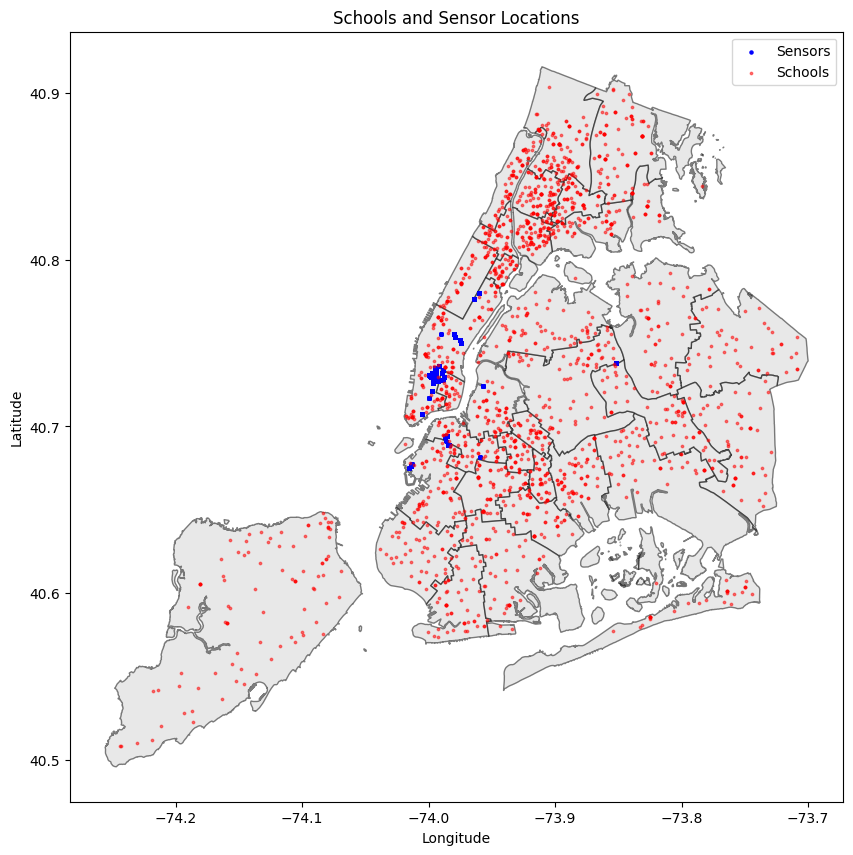

In [25]:
# Set up the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot school districts as polygons
districts_gdf.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)

# Plot sensor locations as points
sensors_gdf.plot(ax=ax, marker='o', color='blue', markersize=5, label="Sensors")

# Plot school locations as points
schoolpoints_gdf.plot(ax=ax, marker='o', color='red', markersize=3, label="Schools", alpha=0.5)

# Add a title and legend
plt.title("Schools and Sensor Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()

# Display the plot
plt.show()

There is only a small region where sensors are located on the school districts map. Let's shrink the map using a bounding box.

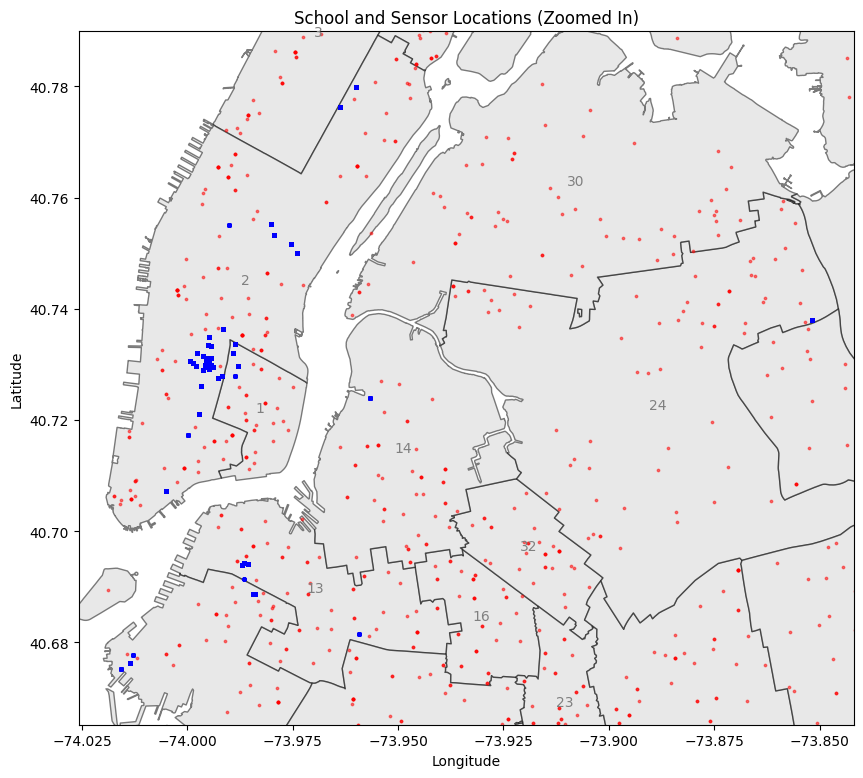

In [26]:
# Define a buffer distance (so no sensor is lying directly on the boundary of the map)
buffer_distance = 0.01

# Calculate the bounding box for the sensor data
minx, miny, maxx, maxy = sensors_gdf.total_bounds

# Expand the bounding box by the buffer distance
expanded_minx = minx - buffer_distance
expanded_miny = miny - buffer_distance
expanded_maxx = maxx + buffer_distance
expanded_maxy = maxy + buffer_distance

# Plot school districts and sensor points within the bounding box
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the school districts
districts_gdf.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)

# Plot the sensor locations
sensors_gdf.plot(ax=ax, marker='o', color='blue', markersize=5)

# Plot school locations as points
schoolpoints_gdf.plot(ax=ax, marker='o', color='red', markersize=3, label="Schools", alpha=0.5)

# Set the plot limits to the bounding box
ax.set_xlim(expanded_minx, expanded_maxx)
ax.set_ylim(expanded_miny, expanded_maxy)

# Add district names as labels
for idx, row in districts_gdf.iterrows():
    # Calculate the centroid of the district for labeling
    centroid = row.geometry.centroid
    ax.annotate(row['school_dis'],
                xy=(centroid.x, centroid.y),
                horizontalalignment='center',
                fontsize=10,
                color='gray')

# Add title and labels
plt.title("School and Sensor Locations (Zoomed In)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [27]:
schoolpoints_gdf

,ATS,Building_C,Location_C,Name,Geographic,Latitude,Longitude,geometry
0,01M015,M015,M015,P.S. 015 Roberto Clemente,1,40.722075,-73.978747,POINT (-73.97875 40.72208)
1,01M020,M020,M020,P.S. 020 Anna Silver,1,40.721305,-73.986312,POINT (-73.98631 40.72131)
2,01M034,M034,M034,P.S. 034 Franklin D. Roosevelt,1,40.726008,-73.975058,POINT (-73.97506 40.72601)
3,01M063,M063,M063,The STAR Academy - P.S.63,1,40.724440,-73.986214,POINT (-73.98621 40.72444)
4,01M064,M064,M064,P.S. 064 Robert Simon,1,40.723130,-73.981597,POINT (-73.9816 40.72313)
...,...,...,...,...,...,...,...,...
1945,88X966,X988,X966,ALC - BRONX EDUCATIONAL CENTER,8,40.816494,-73.890278,POINT (-73.89028 40.81649)
1946,88X994,X358,X994,ALC - Crotona Academy,12,40.829306,-73.892243,POINT (-73.89224 40.82931)
1947,88X995,X896,X995,ALC - Rose Hill Academy,10,40.857248,-73.903165,POINT (-73.90316 40.85725)
1948,88X996,X450,X996,ALC - Stevenson Campus,8,40.821218,-73.855930,POINT (-73.85593 40.82122)


### Find closest schools to each sensor

<div class="alert alert-block alert-warning">
    <b>Note:</b> <b>I will be changing this section of the code</b> after I settle on a more systematic way of deciding which schools to consider in my data analysis. I might only include schools that are within a 1 km radius of each sensor.<br><br>
    <b>Potential challenges to this approach:</b>
    <ul>
        <li>Same school is in 1 km radius of multiple different sensors.</li>
    </ul>
</div>

Let's identify the three closest schools to each sensor.

In [28]:
# Find the closest school for each sensor
# Use same CRS for both GeoDataFrames before calculating distances
projected_crs = "EPSG:32618"
sensors_gdf = sensors_gdf.to_crs(projected_crs)
schoolpoints_gdf = schoolpoints_gdf.to_crs(projected_crs)

# Get unique sensors
unique_sensors = sensors_gdf.drop_duplicates(subset=['sensor_id'])

closest_schools = []

for idx, sensor in unique_sensors.iterrows():
    # Calculate distance from the sensor to all schools
    distances = schoolpoints_gdf.geometry.distance(sensor.geometry)
    
    # Get the indices of the three closest schools
    closest_indices = distances.nsmallest(3).index
    
    # Append the closest school information for each of the three closest schools
    for closest_index in closest_indices:
        closest_schools.append({
            'sensor_id': sensor['sensor_id'],
            'closest_school_id': schoolpoints_gdf.loc[closest_index, 'ATS'],
            'closest_school_distance': distances[closest_index],
            'closest_school_geometry': schoolpoints_gdf.loc[closest_index, 'geometry'],
            'closest_school_name': schoolpoints_gdf.loc[closest_index, 'Name']
        })

# Create a DataFrame to hold the closest schools
closest_schools_df = pd.DataFrame(closest_schools)

<div class="alert alert-block alert-info">
    <b>Note:</b> Distance is measured in meters. We know this because we used EPSG:32618, which is part of a Universal Transverse Mercator (UTM) Zone. The UTM system uses the metric system, where distances are measured in meters.
</div>

In [29]:
closest_schools_df

,sensor_id,closest_school_id,closest_school_distance,closest_school_geometry,closest_school_name
0,0,02M586,130.880384,POINT (585091.4679203543 4509235.826891517),Harvey Milk High School
1,0,75M751,652.508150,POINT (585480.6901603654 4508821.8635961795),Manhattan School for Career Development
2,0,84M202,770.683828,POINT (584198.8314587069 4509325.88836366),Great Oaks Charter School
3,1,84M202,355.642613,POINT (584198.8314587069 4509325.88836366),Great Oaks Charter School
4,1,02M586,541.969509,POINT (585091.4679203543 4509235.826891517),Harvey Milk High School
...,...,...,...,...,...
163,36,13K674,144.542841,POINT (585662.0893452131 4505443.579487185),"City Polytechnic High School of Engineering, A..."
164,36,13K483,152.376010,POINT (585475.7334344881 4505350.949261643),The Urban Assembly School for Law and Justice
165,46,02M374,239.422902,POINT (585529.959282933 4509873.695971327),Gramercy Arts High School
166,46,02M399,239.422902,POINT (585529.959282933 4509873.695971327),The High School For Language And Diplomacy


## Initial Data Exploration

### Analyzing presence of sound during school hours
Noise during school hours can potentially disrupt lessons, test-taking, and other forms of classwork and directly affect a student's performance in school.

In [30]:
import re

presence_counts = pd.DataFrame(index=main_categories)

for cat in main_categories:
    # Find columns that match the pattern (any prefix + category + '_presence')
    presence_cols = [col for col in noise_data.columns if re.search(f".*{cat}.*_presence$", col)]
    
    # Sum values across all matching columns for the category
    total_present = noise_data[presence_cols].sum().sum()
    total_samples = len(noise_data)

    presence_counts.loc[cat, 'total_occurrences'] = total_present
    presence_counts.loc[cat, 'percentage'] = (total_present / total_samples) * 100 if total_samples > 0 else 0

    # School hours analysis (8 AM to 3 PM)
    school_hours = noise_data[noise_data['hour'].between(8, 15)]
    school_present = school_hours[presence_cols].sum().sum()
    school_samples = len(school_hours)

    presence_counts.loc[cat, 'school_hours_percentage'] = \
        (school_present / school_samples) * 100 if school_samples > 0 else 0
    
    # School year analysis (September to June)
    # Filter for months in the range 9 (September) through 6 (June)
    school_year = noise_data[noise_data['date'].dt.month.isin([9, 10, 11, 12, 1, 2, 3, 4, 5, 6])]
    school_year_present = school_year[presence_cols].sum().sum()
    school_year_samples = len(school_year)

    presence_counts.loc[cat, 'school_year_percentage'] = \
        (school_year_present / school_year_samples) * 100 if school_year_samples > 0 else 0


# Display the result
print(presence_counts)

                      total_occurrences  percentage  school_hours_percentage  \
engine                          37266.0   60.085131                58.821388   
machinery-impact                10883.0   17.546999                22.890609   
non-machinery-impact             5838.0    9.412789                10.614784   
powered-saw                      3724.0    6.004321                 8.612931   
alert-signal                    10476.0   16.890781                15.932102   
music                            6175.0    9.956145                 8.103368   
human-voice                     17443.0   28.123892                23.615247   
dog                              4944.0    7.971365                 9.986103   

                      school_year_percentage  
engine                             60.180746  
machinery-impact                   17.410578  
non-machinery-impact                9.265601  
powered-saw                         5.620244  
alert-signal                       17.262177

<div class="alert alert-block alert-warning">
<b>Note:</b> School year start and end dates will vary according to district. Maybe look into this. Currently using September 1 start and June 15 end.
</div>

In [31]:
# Define the school year start and end dates
school_year_start = "09-01"
school_year_end = "06-15"

# Create a mask for school year
school_year_mask = (
    (noise_data['date'].dt.month >= 9) | 
    (noise_data['date'].dt.month <= 6) & 
    (noise_data['date'].dt.day <= 15)
)

# Initialize presence_counts DataFrame
presence_counts = pd.DataFrame(index=main_categories)

for cat in main_categories:
    # Find columns that match the pattern (any prefix + category + '_presence')
    presence_cols = [col for col in noise_data.columns if re.search(f".*{cat}.*_presence$", col)]
    
    # Sum values across all matching columns for the category
    total_present = noise_data[presence_cols].sum().sum()
    total_samples = len(noise_data)

    presence_counts.loc[cat, 'total_occurrences'] = total_present
    presence_counts.loc[cat, 'percentage'] = (total_present / total_samples) * 100 if total_samples > 0 else 0

    # School hours analysis (8 AM to 3 PM) during the school year
    school_hours = noise_data[noise_data['hour'].between(8, 15) & school_year_mask]
    school_present = school_hours[presence_cols].sum().sum()
    school_samples = len(school_hours)

    presence_counts.loc[cat, 'school_hours_percentage'] = \
        (school_present / school_samples) * 100 if school_samples > 0 else 0

print(presence_counts)

                      total_occurrences  percentage  school_hours_percentage
engine                          37266.0   60.085131                59.440256
machinery-impact                10883.0   17.546999                23.029777
non-machinery-impact             5838.0    9.412789                11.086402
powered-saw                      3724.0    6.004321                 7.208331
alert-signal                    10476.0   16.890781                16.244508
music                            6175.0    9.956145                 6.942561
human-voice                     17443.0   28.123892                24.065737
dog                              4944.0    7.971365                10.967077


### Analyzing presence of sound outside of school hours
Noise outside of school hours can also affect school performance since it can disrupt students' concentration while studying and completing homework assignments. Noise in the later hours of the evening can also cause sleep disturbances, which can have detrimental effects on school performance.

### Export to KML file
At this stage, this is for my own personal curiosity. I am exporting this to a KML file so that I can look at these areas in Google Maps.

In [32]:
sensors_map_gdf = gpd.GeoDataFrame(sensors_gdf)
sensors_map_gdf.to_file("sensors_map.kml", driver='KML')

C:\Users\snail\anaconda3\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Lossy conversion occurred when trying to set 64 bit integer field from a real value.
  ogr_write(
